Loading data...
Initializing cross validation...

Model: LinearRegression()

Average MSE: 384.46705646825706

Standard deviation in each CV: 0.3229431580753612

Model: Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

Average MSE: 384.4634924178718

Standard deviation in each CV: 0.322686001932027

Model: RandomForestRegressor(max_depth=25, max_features=25, min_samples_split=60,
                      n_estimators=50, n_jobs=8, verbose=5)

Average MSE: 368.94293966790826

Standard deviation in each CV: 0.42175168166883736

Model: GradientBoostingRegressor(max_depth=5, n_estimators=45, verbose=5)

Average MSE: 387.9605403998997

Standard deviation in each CV: 1.644128963086473
Predictions calculated using model with lowest MSE:
RandomForestRegressor(max_depth=25, max_features=25, min_samples_split=60,
                      n_estimators=50, n_jobs=8, verbose=5)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.4s


building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:   45.4s remaining:    3.9s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   49.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  46 out of  50 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    3.3s finished


[113.23558867  92.99256487 176.43988598 ...  55.56537646 157.7570351
 108.42992931]


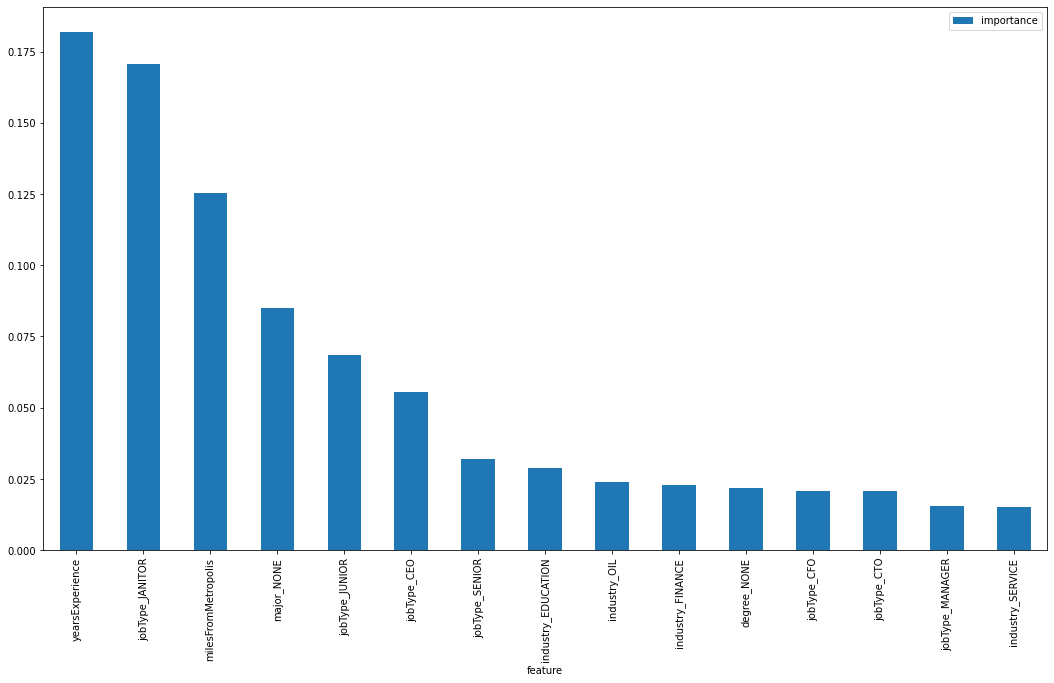

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


def load(file):
    return pd.read_csv(file)

def clean_data(old_df):
    #remove: duplicates on unique values (jobId), NAs for important columns
    #or impossible values (salary<=0)
    new_df=old_df.drop_duplicates(subset=['jobId']).dropna(subset=['jobId'])
    new_df=new_df[new_df.salary>0]
    return new_df

def get_target_df(df,target):
    #optional
    return df[target]

def combine_data(df1, df2, key=None):
    return pd.merge(df1, df2, how='inner')

def one_hot_encode(df, cat_ft=None, num_ft=None):
    cat_df=pd.get_dummies(df[cat_ft])
    num_df=df[num_ft].apply(pd.to_numeric, errors='coerce')
    return pd.concat([cat_df, num_df], axis=1)

def train_model(model, feature_df, target_df,number_proc, mean_mse, cv_std):
    neg_mse=cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring= 'neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
        
def print_summary(model, mean_mse, cv_std):
    print('\nModel:', model)
    print('\nAverage MSE:', mean_mse[model])
    print('\nStandard deviation in each CV:', cv_std[model])

def save_results(model, mean_mse, ml_predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('ml_predictions.csv', predictions, delimiter=',')
    
if __name__ == '__main__':
    #define files for input
    train_feature_file = 'codeprojects/train_features.csv'
    train_target_file = 'codeprojects/train_salaries.csv'
    test_feature_file = 'codeprojects/test_features.csv'

    #define variables
    cat_ft = ['companyId', 'jobType', 'degree', 'major', 'industry']
    num_ft = ['yearsExperience', 'milesFromMetropolis']
    target = 'salary'
    num_procs=mp.cpu_count()
    
    print('Loading data...')
    #load the data
    feature_df = load(train_feature_file)
    target_df = load(train_target_file)
    test_df = load(test_feature_file)

    #combine data for complete training set
    merged_train_df=combine_data(feature_df, target_df, key='jobId')

    #shuffle the complete data for reducing bias and improve cross validation
    new_data=clean_data(merged_train_df)
    shuffled_data=new_data.reindex(np.random.permutation(new_data.index)) 

    #get target
    target_df=shuffled_data[target]

    #update df with encoded categories with one-hot-encoding to prepare for training
    feature_df= one_hot_encode(shuffled_data, cat_ft=cat_ft, num_ft=num_ft)
    test_df=one_hot_encode(test_df, cat_ft=cat_ft, num_ft=num_ft)

    #initialize ML variables
    models = []
    mean_mse = {}
    cv_std = {}
    verbose_lvl=5

    lr = LinearRegression()
    lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    rf = RandomForestRegressor(n_estimators=50, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                                   max_features=25, verbose=verbose_lvl)
    gbm = GradientBoostingRegressor(n_estimators=45, max_depth=5,verbose=verbose_lvl)

    models.extend([lr, lr_std_pca, rf, gbm])

    print("Initializing cross validation...")
    for model in models:
        #plug in dfs with the encoded variables
        train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
        print_summary(model, mean_mse, cv_std)

    #choose model with lowest mse
    model = min(mean_mse, key=mean_mse.get)
    print('Predictions calculated using model with lowest MSE:')
    print(model)

    #train model on entire dataset
    model.fit(feature_df, target_df)

    #create predictions based on test data
    predictions = model.predict(test_df)
    print(predictions)
    #store feature importances
    #note that linear regression models do not have built in feature_importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = [0]*len(feature_df.columns.tolist())
#     print(importances)
    
    feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)

    #set index to 'feature'
    feature_importances.set_index('feature', inplace=True)#, drop=True)

    #create plot
    feature_importances[0:15].plot.bar(figsize=(18,10))
    plt.show()

    #save results
    save_results(model, mean_mse[model], predictions, feature_importances)
